In [3]:
import glob
import logging
from pathlib import Path

import arviz as az
import joblib
import numpy as np
import pandas as pd
import pymc as pm
from matplotlib import pyplot as plt
from sklearn.preprocessing import RobustScaler
from sqlalchemy import create_engine

from ppcx_pymc_func import (
    assign_spatial_priors,
    compute_posterior_assignments,
    plot_1d_velocity_clustering,
    plot_spatial_priors,
)
from src.clustering import preproc_features
from src.config import ConfigManager
from src.database import (
    get_dic_analysis_by_ids,
    get_dic_analysis_ids,
    get_image,
    get_multi_dic_data,
)
from src.logger import setup_logger
from src.preprocessing import apply_dic_filters, spatial_subsample
from src.roi import PolygonROISelector

%matplotlib widget

RANDOM_SEED = 8927
rng = np.random.default_rng(RANDOM_SEED)
logger = setup_logger(logging.INFO, name="ppcx", force=True)

# Load configuration
config = ConfigManager()
db_engine = create_engine(config.db_url)


In [4]:
# Flags to control workflow
SAVE_OUTPUTS = True  # Set to True to save inference results
LOAD_EXISTING = False  # Set to False to run sampling again

# MCMC parameters
DRAWS = 1000  # Number of MCMC draws
TUNE = 500  # Number of tuning steps
CHAINS = 4  # Number of MCMC chains
CORES = 4  # Number of CPU cores to use
TARGET_ACCEPT = 0.9  # Target acceptance rate for NUTS sampler

# Data selection parameters
camera_name = "PPCX_Tele"
reference_start_date = "2024-07-23"
reference_end_date = "2024-08-28"

SUBSAMPLE_FACTOR = 1  # Take every n point
SUBSAMPLE_METHOD = "regular"  # or 'random', 'stratified'
PRIOR_STRENGTH = 0.4  # Between 0 and 1

# Output paths
output_dir = Path("output") / f"{camera_name}_PyMC"
output_dir.mkdir(parents=True, exist_ok=True)
base_name = (
    f"PPCX_mcmc_{camera_name}_pooled_{reference_start_date}_{reference_end_date}"
)

# Get DIC analysis metadata
dic_ids = get_dic_analysis_ids(
    db_engine,
    camera_name=camera_name,
    reference_date_start=reference_start_date,
    reference_date_end=reference_end_date,
)
if len(dic_ids) < 1:
    raise ValueError("No DIC analyses found for the given criteria")

dic_analyses = get_dic_analysis_by_ids(db_engine=db_engine, dic_ids=dic_ids)

# Get master image
master_image_id = dic_analyses["master_image_id"].iloc[0]
img = get_image(master_image_id, camera_name=camera_name)

In [5]:
# Fetch DIC data
out = get_multi_dic_data(dic_ids, stack_results=False)
logger.info(f"Found stack of {len(out)} DIC dataframes. Run filtering...")

# Apply filter for each df in the dictionary and then stack them
filter_kwargs = dict(
    filter_outliers=config.get("dic.filter_outliers"),
    tails_percentile=config.get("dic.tails_percentile"),
    min_velocity=config.get("dic.min_velocity"),
    apply_2d_median=config.get("dic.apply_2d_median"),
    median_window_size=config.get("dic.median_window_size"),
    median_threshold_factor=config.get("dic.median_threshold_factor"),
)
processed = []
for src_id, df_src in out.items():
    try:
        processed.append(apply_dic_filters(df_src, **filter_kwargs))
    except Exception as exc:
        logger.warning("Filtering failed for %s: %s", src_id, exc)
if not processed:
    raise RuntimeError("No dataframes left after filtering.")
df = pd.concat(processed, ignore_index=True)
logger.info("Data shape after filtering and stacking: %s", df.shape)

# Apply ROI filter
selector = PolygonROISelector.from_file(config.get("data.roi_path"))
df = selector.filter_dataframe(df, x_col="x", y_col="y")
logger.info(f"Data shape after filtering: {df.shape}")

# Apply subsampling AFTER ROI filtering
if SUBSAMPLE_FACTOR > 0:
    df_subsampled = spatial_subsample(
        df, n_subsample=SUBSAMPLE_FACTOR, method=SUBSAMPLE_METHOD
    )
    df = df_subsampled
    logger.info(f"Data shape after subsampling: {df.shape}")

# === FEATURE PREPARATION ===
variables_names = config.get("clustering.variables_names")
logger.info(f"Using features: {variables_names}")
df_features = preproc_features(df)
X = df_features[variables_names].values
scaler = RobustScaler()
X_scaled = scaler.fit_transform(X)
logger.info(f"Feature matrix shape: {X_scaled.shape}")

2025-09-11 18:22:19 | [INFO    ] Found stack of 6 DIC dataframes. Run filtering...
2025-09-11 18:22:22 | [INFO    ] Data shape after filtering and stacking: (20994, 5)
2025-09-11 18:22:22 | [INFO    ] Data shape after filtering: (11233, 5)
2025-09-11 18:22:22 | [INFO    ] Data shape after subsampling: (11233, 5)
2025-09-11 18:22:22 | [INFO    ] Using features: ['V']
2025-09-11 18:22:22 | [INFO    ] Feature matrix shape: (11233, 1)


Filtered 20994 points to 11233 points inside polygon
Subsampled from 11233 to 11233 points (100.0%)


2025-09-11 18:22:22 | [INFO    ] Found 4 sector polygons for priors
2025-09-11 18:22:22 | [INFO    ] Sector 0: 1238 points with strong prior
2025-09-11 18:22:22 | [INFO    ] Sector 1: 2141 points with strong prior
2025-09-11 18:22:22 | [INFO    ] Sector 2: 2245 points with strong prior
2025-09-11 18:22:22 | [INFO    ] Sector 3: 4976 points with strong prior


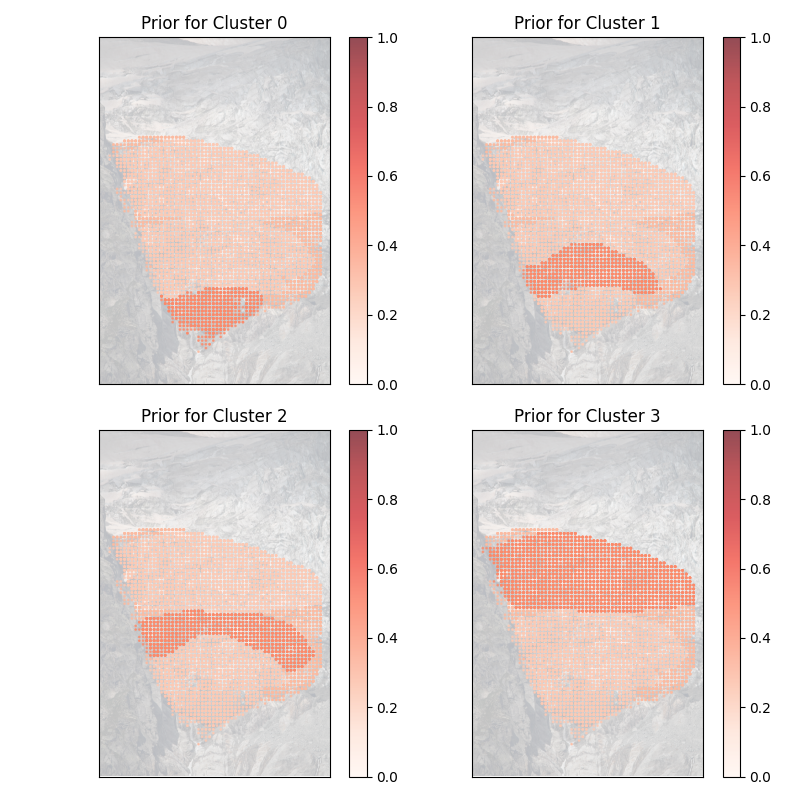

In [6]:
# === SPATIAL PRIOR SETUP ===
sector_files = sorted(glob.glob(config.get("data.sector_prior_pattern")))
sectors = [PolygonROISelector.from_file(f) for f in sector_files]
logger.info(f"Found {len(sectors)} sector polygons for priors")

prior_probs = assign_spatial_priors(df, sectors, prior_strength=PRIOR_STRENGTH)
plot_spatial_priors(df, prior_probs, img=img);

In [ ]:
# # Simple, not marginalized model (z discrete) --> slower sampling, but direct cluster assignments

# n_features = X_scaled.shape[1]
# n_data = X_scaled.shape[0]
# k = len(sectors)  # number of clusters = number of sectors
#
# with pm.Model(
#     coords={"cluster": range(k), "feature": range(n_features), "obs": range(ndata)}
# ) as simple_model:
#     # Cluster means
#     μ = pm.Normal("μ", mu=0, sigma=1, dims=("cluster", "feature"))

#     # Cluster standard deviations (diagonal covariance)
#     σ = pm.HalfNormal("σ", sigma=0.5, dims=("cluster", "feature"))

#     # Cluster assignments with spatial priors
#     z = pm.Categorical("z", p=prior_probs, dims="obs")

#     # Likelihood: each point comes from its assigned cluster
#     observations = pm.Normal(
#         "x_obs", mu=μ[z], sigma=σ[z], observed=X_scaled, dims=("obs", "feature")
#     )

# with simple_model:
#     prior_samples = pm.sample_prior_predictive(100)

# fig, ax = plt.subplots(figsize=(8, 4))
# az.plot_dist(
#     X_scaled,
#     kind="hist",
#     color="C1",
#     hist_kwargs={"alpha": 0.6},
#     label="observed",
# )
# az.plot_dist(
#     prior_samples.prior_predictive["x_obs"],
#     kind="hist",
#     hist_kwargs={"alpha": 0.6},
#     label="simulated",
# )
# plt.xticks(rotation=45);

In [ ]:
# Marginalized mixture model (no discrete z) --> faster sampling, but no direct cluster assignments
n_features = X_scaled.shape[1]
n_data = X_scaled.shape[0]
k = len(sectors)  # number of clusters = number of sectors

with pm.Model(
    coords={"obs": range(n_data), "cluster": range(k), "feature": range(n_features)}
) as model:
    obs_data = pm.Data("obs_data", X_scaled, dims=("obs", "feature"))
    prior_w = pm.Data(
        "prior_w", prior_probs.reshape(n_data, k), dims=("obs", "cluster")
    )

    mu = pm.Normal("mu", 0, 1, dims=("cluster", "feature"))
    sigma = pm.HalfNormal("sigma", 0.5, dims=("cluster", "feature"))

    # Log weights with small constant to avoid log(0)
    log_w = pm.Deterministic(
        "log_w", pm.math.log(prior_w + 1e-12), dims=("obs", "cluster")
    )

    # Per-cluster log-likelihood
    x_centered = (obs_data[:, None, :] - mu[None, :, :]) / sigma[None, :, :]
    logp_feat = -0.5 * (
        pm.math.log(2 * np.pi) + 2 * pm.math.log(sigma[None, :, :]) + x_centered**2
    )
    logp_clusters = logp_feat.sum(axis=2)  # (obs, cluster)

    # Mixture log likelihood (marginalized over clusters)
    log_mix = pm.logsumexp(logp_clusters + log_w, axis=1)  # (obs,)

    # Total logp as Potential
    pm.Potential("mixture_logp", log_mix.sum())

logger.info("Marginalized mixture model created (no discrete z).")


2025-09-11 18:22:33 | [INFO    ] Marginalized mixture model created (no discrete z).


GitHub Copilot

Below: the “simple” (non‑marginalized) finite mixture with explicit discrete assignments z, its priors, likelihood, posterior, and how MCMC proceeds.

1. Generative model (per observation i = 1..N, features f = 1..F, clusters c = 1..K):
   a) Cluster (component) parameters
      μ_{c,f} ~ Normal(0, 1)
      σ_{c,f} ~ HalfNormal(0.5)
      (Independent across clusters and features; diagonal covariance.)
   b) Spatial / external prior weights (given, not random):
      π_{i,c}  with  Σ_c π_{i,c} = 1  and  π_{i,c} ≥ 0.
   c) Latent assignment
      z_i ~ Categorical( π_{i,1:K} ).
   d) Observation conditional on assignment
      x_{i,f} | z_i = c  ~ Normal( μ_{c,f}, σ_{c,f} ), independent over f.
   Vector form:
      p(x_i | z_i=c, μ, σ) = ∏_{f=1}^F Normal( x_{i,f} | μ_{c,f}, σ_{c,f} ).

2. Joint density
   p(μ, σ, z, x) =
     [∏_{c=1}^K ∏_{f=1}^F p(μ_{c,f}) p(σ_{c,f})] *
     ∏_{i=1}^N [ π_{i,z_i} * ∏_{f=1}^F Normal(x_{i,f} | μ_{z_i,f}, σ_{z_i,f}) ].

3. Priors
   - Component means: independent standard Normal.
   - Component scales: HalfNormal(0.5).
   - Latent z_i: Categorical with known per‑observation probability vector π_i (your spatial prior).
   These define p(μ, σ, z) = p(μ) p(σ) ∏_i p(z_i | π_i).
   Note: z prior is not symmetric if π_i vary spatially.

4. Likelihood
   p(x | μ, σ, z) = ∏_{i=1}^N ∏_{f=1}^F Normal( x_{i,f} | μ_{z_i,f}, σ_{z_i,f} ).

5. Posterior
   p(μ, σ, z | x) ∝ p(μ, σ, z, x) =
     p(μ) p(σ) ∏_{i} [ π_{i,z_i} * ∏_{f} Normal(x_{i,f} | μ_{z_i,f}, σ_{z_i,f}) ].
   No closed form because of coupling of (μ, σ) across all i through shared assignments.

6. Marginal (if you integrate out z):
   p(μ, σ | x) ∝ p(μ) p(σ) ∏_{i} Σ_{c} π_{i,c} ∏_{f} Normal(x_{i,f} | μ_{c,f}, σ_{c,f}).
   (This is what you coded in the marginalized version.)

7. Conditional posteriors (intuition)
   - For continuous (μ, σ) given z: conjugacy is broken because σ has HalfNormal prior; PyMC uses gradient-based NUTS (if z marginalized) or combination sampler if z explicit.
   - For z_i given (μ, σ):
       p(z_i = c | rest) ∝ π_{i,c} * ∏_{f} Normal(x_{i,f} | μ_{c,f}, σ_{c,f}).
     This is a normalized K-vector (responsibilities).

8. MCMC with explicit z
   - Mixed discrete + continuous.
   - PyMC typically assigns:
     * NUTS (or HMC) cannot operate over discrete z.
     * So z_i are updated via a categorical Gibbs / Metropolis-like step (CategoricalGibbsMetropolis or Metropolis).
     * μ, σ updated conditional on current z using gradient-based steps only if z were marginalized; here, because z is discrete, PyMC usually falls back to a compound step: z via discrete sampler; μ, σ via NUTS may be disabled if the logp is not differentiable in z path (often PyMC will give you a mix of samplers).
   - This yields slower mixing because:
     * High-dimensional discrete state (N latent integers).
     * Strong posterior correlations (label switching risk if priors symmetric).
   - Spatial prior π_i helps break label symmetry (reduces label switching).

9. Monte Carlo Markov Chain principle
   Goal: draw samples from target posterior p(μ, σ, z | x).
   Construct a Markov chain with transition kernel K preserving (invariant) that posterior. After burn-in (tuning), chain state distribution approximates target.
   For Metropolis-Hastings (conceptually for any block):
     - Propose θ' ~ q(θ' | θ).
     - Accept with prob α = min(1, [p(θ'|x) q(θ|θ')]/[p(θ|x) q(θ'|θ)]).
   For Gibbs (categorical z_i):
     - Sample exactly from full conditional p(z_i | μ, σ, x_i).
     - Always accepted (α=1).
   For gradient HMC / NUTS (continuous block):
     - Simulate Hamiltonian dynamics using gradients of log posterior; accept with Metropolis correction controlling integrator error.
   Chain ergodicity ⇒ empirical averages converge: (1/S) Σ g(θ^{(s)}) → E[g | data].

10. Responsibilities (posterior cluster probabilities) with explicit z
    After sampling S draws:
      Approx p(z_i = c | x) ≈ (1/S) Σ_{s} 1{ z_i^{(s)} = c }.
    In marginalized model you compute:
      r_{i,c}^{(s)} = softmax_c( ℓ_{i,c}^{(s)} + log π_{i,c} )
      and average r_{i,c}^{(s)} over draws.

11. When to keep discrete z
    - Needed if you want direct samples of assignments for downstream discrete summaries.
    - Not needed if only cluster parameters and posterior probabilities matter (marginalization preferable).

12. Practical issues
    - Label switching: mitigated by informative spatial π_i (asymmetric).
    - Mixing: discrete z slows convergence; thinning does not fix slow mixing—need better parameterization or marginalization.
    - Diagnostics: check R-hat, ESS for μ, σ; for z you can inspect cluster occupancy trace.

13. Summary of components
    Prior: p(μ) p(σ) ∏_i Categorical(z_i | π_i)
    Likelihood: ∏_i ∏_f Normal(x_{i,f} | μ_{z_i,f}, σ_{z_i,f})
    Posterior: proportional product of the two.
    MCMC: alternate (conceptually) updating discrete z and continuous parameters to explore posterior.

Let me know if you want an explicit PyMC code block for the discrete version with current shapes.

In [9]:
# Sampling (now NUTS can be used for mu, sigma)
posterior_path = output_dir / f"{base_name}_posterior.idata.nc"
if LOAD_EXISTING is False or not posterior_path.exists():
    with model:
        logger.info("Starting MCMC sampling...")
        idata = pm.sample(
            target_accept=TARGET_ACCEPT,
            draws=DRAWS,
            tune=TUNE,
            chains=CHAINS,
            cores=CORES,
            random_seed=RANDOM_SEED,
        )
    logger.info("Sampling completed!")

    # save the posterior InferenceData object and the scaler
    if SAVE_OUTPUTS:
        az.to_netcdf(idata, posterior_path)
        joblib.dump(scaler, output_dir / f"{base_name}_scaler.joblib")
        logger.info(f"Outputs saved to {output_dir}")
else:
    logger.info("Loading existing posterior InferenceData object...")
    idata = az.from_netcdf(posterior_path)

2025-09-11 18:22:36 | [INFO    ] Starting MCMC sampling...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [mu, sigma]


Output()

Sampling 4 chains for 500 tune and 1_000 draw iterations (2_000 + 4_000 draws total) took 193 seconds.
2025-09-11 18:25:52 | [INFO    ] Sampling completed!
2025-09-11 18:26:05 | [INFO    ] Outputs saved to output/PPCX_Tele_PyMC


In [14]:
print(az.summary(idata, var_names=["mu", "sigma"]))

              mean     sd  hdi_3%  hdi_97%  mcse_mean  mcse_sd  ess_bulk  \
mu[0, 0]     0.043  0.016   0.012    0.071      0.000      0.0    2876.0   
mu[1, 0]     0.661  0.025   0.613    0.707      0.001      0.0    2363.0   
mu[2, 0]     0.238  0.026   0.190    0.289      0.001      0.0    2307.0   
mu[3, 0]    -0.903  0.010  -0.923   -0.885      0.000      0.0    3371.0   
sigma[0, 0]  0.256  0.010   0.239    0.276      0.000      0.0    3471.0   
sigma[1, 0]  0.557  0.017   0.524    0.588      0.000      0.0    2644.0   
sigma[2, 0]  0.388  0.015   0.361    0.418      0.000      0.0    2909.0   
sigma[3, 0]  0.377  0.007   0.364    0.390      0.000      0.0    3270.0   

             ess_tail  r_hat  
mu[0, 0]       2792.0    1.0  
mu[1, 0]       2852.0    1.0  
mu[2, 0]       2588.0    1.0  
mu[3, 0]       2814.0    1.0  
sigma[0, 0]    2894.0    1.0  
sigma[1, 0]    3006.0    1.0  
sigma[2, 0]    2778.0    1.0  
sigma[3, 0]    3083.0    1.0  


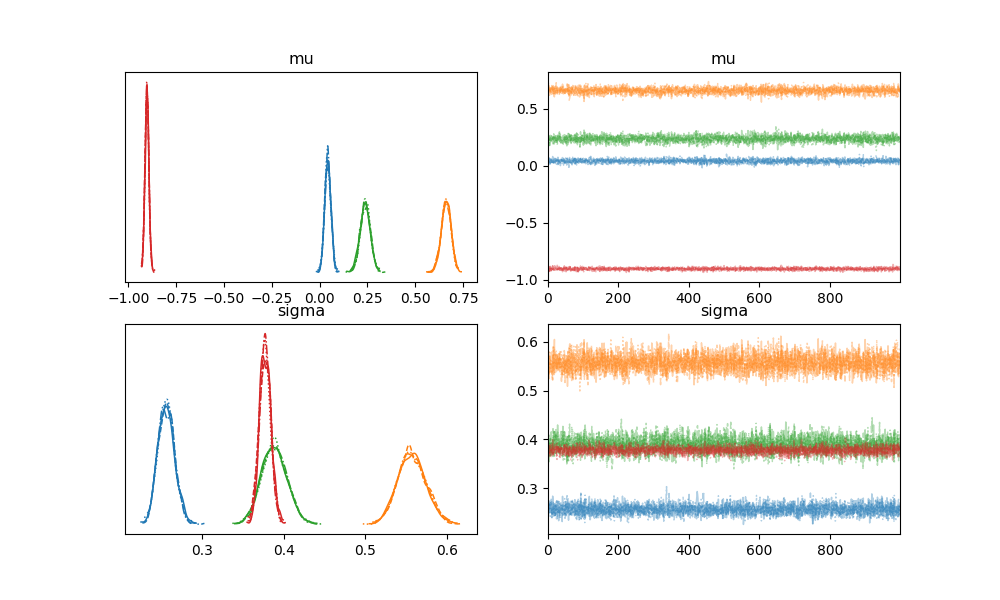

In [15]:
# Plot trace plots
fig, axes = plt.subplots(2, 2, figsize=(10, 6))
az.plot_trace(idata, var_names=["mu", "sigma"], axes=axes, compact=True)
if SAVE_OUTPUTS:
    fig.savefig(output_dir / f"{base_name}_trace_plots.png", dpi=150)

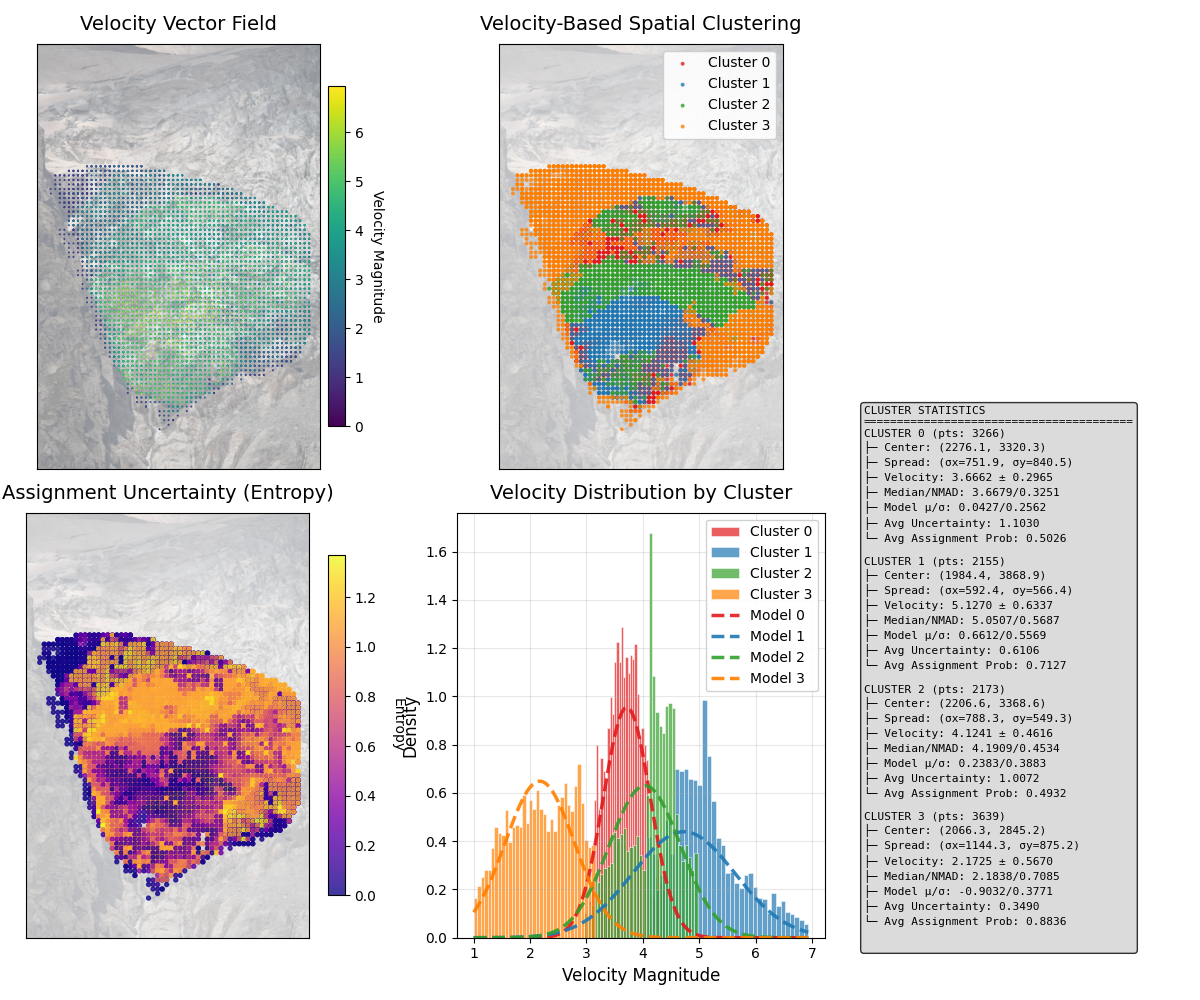

In [20]:
## === POSTERIOR ANALYSIS: ASSIGN POINTS TO CLUSTERS ===

# compute cluster assignments (subsample 200 posterior draws to save time)
posterior_probs, cluster_pred, uncertainty = compute_posterior_assignments(
    idata, X_scaled, prior_probs, n_posterior_samples=200
)
fig, uncertainty = plot_1d_velocity_clustering(
    df_features,
    img,
    idata=idata,
    cluster_pred=cluster_pred,
    posterior_probs=posterior_probs,
    scaler=scaler,
)
if SAVE_OUTPUTS:
    fig.savefig(output_dir / f"{base_name}_results.png", dpi=300, bbox_inches="tight")